In [36]:
# Libraries
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [37]:
# MYSQL Connection string

config = {
  'user': 'root',
  'password': 'Nls@123',
  'host': '127.0.0.1',
  'database': 'kollect_musoni',
  'auth_plugin' : 'mysql_native_password',
  'raise_on_warnings': True
}

In [3]:
# Fetch the data from DB
mysql_connection = mysql.connector.connect(**config)
df = pd.read_sql('SELECT * from customer$information', con=mysql_connection)
mysql_connection.close()
df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,...,VERSION_NUMBER,GROUP_NAME,DELINQUENCY_STRING,DELINQUENT_STATUS,DAO_AREA,LOAN_STATUS,REPAY_FREQUENCY,REPAY_CURRENCY,LOAN_TYPE,STAGE
0,102827,,,,,Active,,9,NO,Unreachable: Out of reach,...,2,Individual,PERSONAL BANKING,,,Active,e0Y e1M e0W o27D e0F,,79,COLLECTION
1,10337,,,,,Active,,16,YES,PTP,...,2,Individual,PERSONAL BANKING,,,Active,e0Y e1M e0W o28D e0F,,32,
2,10337,,,,,Active,,16,NO,Unreachable: Ringing no answer,...,3,Individual,PERSONAL BANKING,,,Active,e0Y e1M e0W o27D e0F,,32,
3,10337,,,,,Active,,16,NO,Unwilling to Pay,...,4,Individual,PERSONAL BANKING,,,Active,e0Y e1M e0W o28D e0F,,32,
4,104309,,,,,Active,,3,NO,Unreachable: Out of reach,...,2,Individual,PERSONAL BANKING,,,Active,e0Y e1M e0W o28D e0F,,52,


In [4]:
# Replacing the empty string to NA
df.replace(r'', np.NaN, inplace=True)
# Validating the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    389 non-null    object 
 1   GENDER                0 non-null      float64
 2   CUSTOMER_RISK_STATUS  0 non-null      float64
 3   INDUSTRY              0 non-null      float64
 4   RESIDENCE             0 non-null      float64
 5   CUSTOMER_STATUS       389 non-null    object 
 6   SEGMENT               0 non-null      float64
 7   BRANCH                389 non-null    object 
 8   PROMISE_SUCCESS       389 non-null    object 
 9   OUTCOME               389 non-null    object 
 10  TIME_STAMP            389 non-null    object 
 11  ACTIVITY              389 non-null    object 
 12  VERSION_NUMBER        389 non-null    object 
 13  GROUP_NAME            389 non-null    object 
 14  DELINQUENCY_STRING    389 non-null    object 
 15  DELINQUENT_STATUS     0

In [5]:
# Dropping further NULL values columns
df = df.drop(["GENDER","CUSTOMER_RISK_STATUS","INDUSTRY","RESIDENCE",
             "SEGMENT","DELINQUENT_STATUS","DAO_AREA","REPAY_CURRENCY"], axis = 1)

In [6]:
# Removing the duplicated values
df = df.drop_duplicates(["ID", "TIME_STAMP"],ignore_index = True)

In [7]:
# Missing value treatment
# Using forward fill replacing the NA values
df = df.fillna(method='ffill')

# Changing timestamp to pandas datetime
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'], errors='coerce')

# Droping the NA Rows
df.dropna(inplace=True) 
df.reset_index(drop=True, inplace=True)


# Revalidating the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  389 non-null    object        
 1   CUSTOMER_STATUS     389 non-null    object        
 2   BRANCH              389 non-null    object        
 3   PROMISE_SUCCESS     389 non-null    object        
 4   OUTCOME             389 non-null    object        
 5   TIME_STAMP          389 non-null    datetime64[ns]
 6   ACTIVITY            389 non-null    object        
 7   VERSION_NUMBER      389 non-null    object        
 8   GROUP_NAME          389 non-null    object        
 9   DELINQUENCY_STRING  389 non-null    object        
 10  LOAN_STATUS         389 non-null    object        
 11  REPAY_FREQUENCY     389 non-null    object        
 12  LOAN_TYPE           389 non-null    object        
 13  STAGE               389 non-null    object        

In [8]:
# In the above dataframe dropping ACTIVITY,VERSION_NUMBER columns
# ACTIVITY will be only call and added for data filter purpose
# VERSION_NUMBER will be only for same customers call count

df = df.drop(["ACTIVITY","VERSION_NUMBER"], axis = 1)
df.head()

,ID,CUSTOMER_STATUS,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DELINQUENCY_STRING,LOAN_STATUS,REPAY_FREQUENCY,LOAN_TYPE,STAGE
0,102827,Active,9,NO,Unreachable: Out of reach,2022-02-21 16:55:26,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,79,COLLECTION
1,10337,Active,16,YES,PTP,2022-02-21 11:21:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION
2,10337,Active,16,NO,Unreachable: Ringing no answer,2022-03-03 15:40:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,32,COLLECTION
3,10337,Active,16,NO,Unwilling to Pay,2022-03-07 11:41:20,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION
4,104309,Active,3,NO,Unreachable: Out of reach,2022-03-10 11:43:16,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,52,COLLECTION


In [9]:
# Creating hours to sessions 

df_time = pd.DataFrame({'hour':range(0, 24)})

split = [0,3,5,9,12,14,16,18,20,23]
session = ['Late_Night','Early_Morning','Morning','Late_Morning','Afteroon','Late_Afternoon','Evening','Late_Evening','Night']
df_time['session'] = pd.cut(df_time['hour'], bins=split, labels=session, include_lowest=True)

In [10]:
# Converting timestamp to session

split = [0,3,5,9,12,14,16,18,20,23]
session = ['Late_Night','Early_Morning','Morning','Late_Morning','Afteroon','Late_Afternoon','Evening','Late_Evening','Night']
df['SESSION'] = pd.cut(df.TIME_STAMP.dt.hour, bins=split, labels=session, include_lowest=True)

df.head()

,ID,CUSTOMER_STATUS,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DELINQUENCY_STRING,LOAN_STATUS,REPAY_FREQUENCY,LOAN_TYPE,STAGE,SESSION
0,102827,Active,9,NO,Unreachable: Out of reach,2022-02-21 16:55:26,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,79,COLLECTION,Late_Afternoon
1,10337,Active,16,YES,PTP,2022-02-21 11:21:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION,Late_Morning
2,10337,Active,16,NO,Unreachable: Ringing no answer,2022-03-03 15:40:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,32,COLLECTION,Late_Afternoon
3,10337,Active,16,NO,Unwilling to Pay,2022-03-07 11:41:20,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION,Late_Morning
4,104309,Active,3,NO,Unreachable: Out of reach,2022-03-10 11:43:16,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,52,COLLECTION,Late_Morning


In [11]:
# Analyzing categorical values in the dataframe
cols = df.columns
num_cols = df._get_numeric_data().columns
categorical_col = list(set(cols) - set(num_cols))
    
categorical_col

['REPAY_FREQUENCY',
 'ID',
 'STAGE',
 'OUTCOME',
 'GROUP_NAME',
 'SESSION',
 'LOAN_TYPE',
 'PROMISE_SUCCESS',
 'BRANCH',
 'TIME_STAMP',
 'CUSTOMER_STATUS',
 'LOAN_STATUS',
 'DELINQUENCY_STRING']

In [12]:
# Validating the catorical values (Duplicates)
print("LOAN_TYPE",df['LOAN_TYPE'].unique())
print("GROUP_NAME",df['GROUP_NAME'].unique())
print("PROMISE_SUCCESS",df['PROMISE_SUCCESS'].unique())
print("CUSTOMER_STATUS",df['CUSTOMER_STATUS'].unique())
print("OUTCOME",df['OUTCOME'].unique())
print("REPAY_FREQUENCY",df['REPAY_FREQUENCY'].unique())

print("STAGE",df['STAGE'].unique())
print("LOAN_STATUS",df['LOAN_STATUS'].unique())
print("BRANCH",df['BRANCH'].unique())
print("DELINQUENCY_STRING",df['DELINQUENCY_STRING'].unique())
print("SESSION",df['SESSION'].unique())

LOAN_TYPE ['79' '32' '52' '67' '59' '74' '18' '70' '24' '95' '68' '4' '1' '35' '17'
 '99' '78' '89' '75' '81' '16' '100' '19' '15' '84' '8' '13']
GROUP_NAME ['Individual']
PROMISE_SUCCESS ['NO' 'YES']
CUSTOMER_STATUS ['Active']
OUTCOME ['Unreachable: Out of reach' 'PTP' 'Unreachable: Ringing no answer'
 'Unwilling to Pay' 'NIP' 'Unreachable: Out of Service'
 'Client Capacity Issues' 'Invalid Contact: Wrong Number'
 'Client Situation Unconfirmed' 'SKIP TRACE' 'SIP'
 'Client Situation Confirmed' 'Language Barrier' 'Arrears Cause Confirmed'
 'DECEASED' 'Unreachable: Engaged']
REPAY_FREQUENCY ['e0Y e1M e0W o27D e0F' 'e0Y e1M e0W o28D e0F']
STAGE ['COLLECTION']
LOAN_STATUS ['Active' 'Restructured' 'Closed (obligations met)' 'Closed (written off)']
BRANCH ['9' '16' '3' '2' '11' '8' '4' '41' '6' '10' '14' '5' '7' '29' '27' '31'
 '32']
DELINQUENCY_STRING ['PERSONAL BANKING']
SESSION ['Late_Afternoon', 'Late_Morning', 'Evening', 'Morning', 'Afteroon', 'Late_Night']
Categories (9, object): ['Lat

In [13]:
# Changing dataframe columns datatype
df['LOAN_TYPE'] = df['LOAN_TYPE'].astype('int')
df['BRANCH'] = df['BRANCH'].astype('int')

# Replacing the empty string to NA
df.replace(r'', np.NaN, inplace=True)

# Droping the NA Rows
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [14]:
# Analyzing the dependent variable categories
print('dependent variable categories -Sessions' ,df['SESSION'].unique())

# count values of each categories 
print(df['SESSION'].value_counts())

dependent variable categories -Sessions ['Late_Afternoon', 'Late_Morning', 'Evening', 'Morning', 'Afteroon', 'Late_Night']
Categories (9, object): ['Late_Night' < 'Early_Morning' < 'Morning' < 'Late_Morning' ... 'Late_Afternoon' < 'Evening' < 'Late_Evening' < 'Night']
Late_Morning      216
Late_Afternoon     91
Morning            42
Afteroon           31
Evening             8
Late_Night          1
Early_Morning       0
Late_Evening        0
Night               0
Name: SESSION, dtype: int64


In [15]:
# Grouping the ID with sessions to get each customer call count against each session
df['FREQ'] = df.groupby(["ID","SESSION","PROMISE_SUCCESS"])['SESSION'].transform('count')
df.head()

,ID,CUSTOMER_STATUS,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DELINQUENCY_STRING,LOAN_STATUS,REPAY_FREQUENCY,LOAN_TYPE,STAGE,SESSION,FREQ
0,102827,Active,9,NO,Unreachable: Out of reach,2022-02-21 16:55:26,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,79,COLLECTION,Late_Afternoon,1
1,10337,Active,16,YES,PTP,2022-02-21 11:21:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION,Late_Morning,1
2,10337,Active,16,NO,Unreachable: Ringing no answer,2022-03-03 15:40:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,32,COLLECTION,Late_Afternoon,1
3,10337,Active,16,NO,Unwilling to Pay,2022-03-07 11:41:20,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION,Late_Morning,1
4,104309,Active,3,NO,Unreachable: Out of reach,2022-03-10 11:43:16,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,52,COLLECTION,Late_Morning,1


In [16]:
# Removing the duplicated values
df = df.drop_duplicates(["ID","SESSION","PROMISE_SUCCESS","LOAN_STATUS"],ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID                  342 non-null    object        
 1   CUSTOMER_STATUS     342 non-null    object        
 2   BRANCH              342 non-null    int64         
 3   PROMISE_SUCCESS     342 non-null    object        
 4   OUTCOME             342 non-null    object        
 5   TIME_STAMP          342 non-null    datetime64[ns]
 6   GROUP_NAME          342 non-null    object        
 7   DELINQUENCY_STRING  342 non-null    object        
 8   LOAN_STATUS         342 non-null    object        
 9   REPAY_FREQUENCY     342 non-null    object        
 10  LOAN_TYPE           342 non-null    int64         
 11  STAGE               342 non-null    object        
 12  SESSION             342 non-null    category      
 13  FREQ                342 non-null    int64         

In [17]:
# Analyzing the call count
print("Frequency call unique count",df['FREQ'].unique())
print("Frequency call count",len(df['FREQ'].unique()))

Frequency call unique count [1 2 3 4]
Frequency call count 4


In [18]:
# pivoting the table using unique id and promise status
df_pivot = df.pivot_table(index=['ID', 'PROMISE_SUCCESS'], columns='SESSION', values='FREQ').reset_index()
df_pivot.fillna(0, inplace=True)
df_pivot.head()

SESSION,ID,PROMISE_SUCCESS,Late_Night,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening
0,102827,NO,0.0,0.0,0.0,0.0,1.0,0.0
1,10337,NO,0.0,0.0,1.0,0.0,1.0,0.0
2,10337,YES,0.0,0.0,1.0,0.0,0.0,0.0
3,104309,NO,0.0,0.0,1.0,0.0,0.0,0.0
4,104909,NO,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
# merging 2 dataframes
df = pd.merge(df, df_pivot, on=['ID','PROMISE_SUCCESS'])
df = df.drop_duplicates(["ID","PROMISE_SUCCESS","LOAN_STATUS"],ignore_index = True)
df.head()

,ID,CUSTOMER_STATUS,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DELINQUENCY_STRING,LOAN_STATUS,REPAY_FREQUENCY,LOAN_TYPE,STAGE,SESSION,FREQ,Late_Night,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening
0,102827,Active,9,NO,Unreachable: Out of reach,2022-02-21 16:55:26,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,79,COLLECTION,Late_Afternoon,1,0.0,0.0,0.0,0.0,1.0,0.0
1,10337,Active,16,YES,PTP,2022-02-21 11:21:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,32,COLLECTION,Late_Morning,1,0.0,0.0,1.0,0.0,0.0,0.0
2,10337,Active,16,NO,Unreachable: Ringing no answer,2022-03-03 15:40:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,32,COLLECTION,Late_Afternoon,1,0.0,0.0,1.0,0.0,1.0,0.0
3,104309,Active,3,NO,Unreachable: Out of reach,2022-03-10 11:43:16,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,52,COLLECTION,Late_Morning,1,0.0,0.0,1.0,0.0,0.0,0.0
4,104909,Active,3,NO,NIP,2022-03-15 16:03:26,Individual,PERSONAL BANKING,Restructured,e0Y e1M e0W o28D e0F,67,COLLECTION,Late_Afternoon,1,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# Added preffered session to the respective customer
avl_session = df['SESSION'].unique().tolist()
df['PREF_SESSION'] = df[avl_session].idxmax(axis=1)
df.head()

,ID,CUSTOMER_STATUS,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DELINQUENCY_STRING,LOAN_STATUS,REPAY_FREQUENCY,...,STAGE,SESSION,FREQ,Late_Night,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,PREF_SESSION
0,102827,Active,9,NO,Unreachable: Out of reach,2022-02-21 16:55:26,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,...,COLLECTION,Late_Afternoon,1,0.0,0.0,0.0,0.0,1.0,0.0,Late_Afternoon
1,10337,Active,16,YES,PTP,2022-02-21 11:21:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,...,COLLECTION,Late_Morning,1,0.0,0.0,1.0,0.0,0.0,0.0,Late_Morning
2,10337,Active,16,NO,Unreachable: Ringing no answer,2022-03-03 15:40:55,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o27D e0F,...,COLLECTION,Late_Afternoon,1,0.0,0.0,1.0,0.0,1.0,0.0,Late_Afternoon
3,104309,Active,3,NO,Unreachable: Out of reach,2022-03-10 11:43:16,Individual,PERSONAL BANKING,Active,e0Y e1M e0W o28D e0F,...,COLLECTION,Late_Morning,1,0.0,0.0,1.0,0.0,0.0,0.0,Late_Morning
4,104909,Active,3,NO,NIP,2022-03-15 16:03:26,Individual,PERSONAL BANKING,Restructured,e0Y e1M e0W o28D e0F,...,COLLECTION,Late_Afternoon,1,0.0,0.0,0.0,0.0,1.0,0.0,Late_Afternoon


In [21]:
# Removing the below columns from the dataframe
# ID, performed all operations against the unique id
# CUSTOMER_STATUS, only to fetch active customers
# TIME_STAMP converted to sessions
# FREQ,SESSION for developer reference
df = df.drop(["ID","CUSTOMER_STATUS","TIME_STAMP","FREQ","SESSION"], axis = 1)

In [22]:
# As per the PCA, XGB model importance and bussiness inputs dropping the below columns and recreation of 
# model with new dataset
df = df.drop(["OUTCOME","GROUP_NAME","DELINQUENCY_STRING","REPAY_FREQUENCY"], axis = 1)
df.head()

,BRANCH,PROMISE_SUCCESS,LOAN_STATUS,LOAN_TYPE,STAGE,Late_Night,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,PREF_SESSION
0,9,NO,Active,79,COLLECTION,0.0,0.0,0.0,0.0,1.0,0.0,Late_Afternoon
1,16,YES,Active,32,COLLECTION,0.0,0.0,1.0,0.0,0.0,0.0,Late_Morning
2,16,NO,Active,32,COLLECTION,0.0,0.0,1.0,0.0,1.0,0.0,Late_Afternoon
3,3,NO,Active,52,COLLECTION,0.0,0.0,1.0,0.0,0.0,0.0,Late_Morning
4,3,NO,Restructured,67,COLLECTION,0.0,0.0,0.0,0.0,1.0,0.0,Late_Afternoon


In [23]:
ONEHOT_LIST = ["PROMISE_SUCCESS","LOAN_STATUS","STAGE"]

IP_ONEHOT = []

for i in ONEHOT_LIST:
    IP_ONEHOT.append(df[i].unique().tolist())
    
IP_ONEHOT

[['NO', 'YES'],
 ['Active',
  'Restructured',
  'Closed (obligations met)',
  'Closed (written off)'],
 ['COLLECTION']]

In [24]:
# To do one hot encode the categories
# added the parameter drop_first is true in one hot , always n-1 columns enough to explain the categories
df_final = pd.get_dummies(df, drop_first =True ,columns=["PROMISE_SUCCESS","LOAN_STATUS",
                                                         "STAGE"],dtype = int,
                          sparse=True)

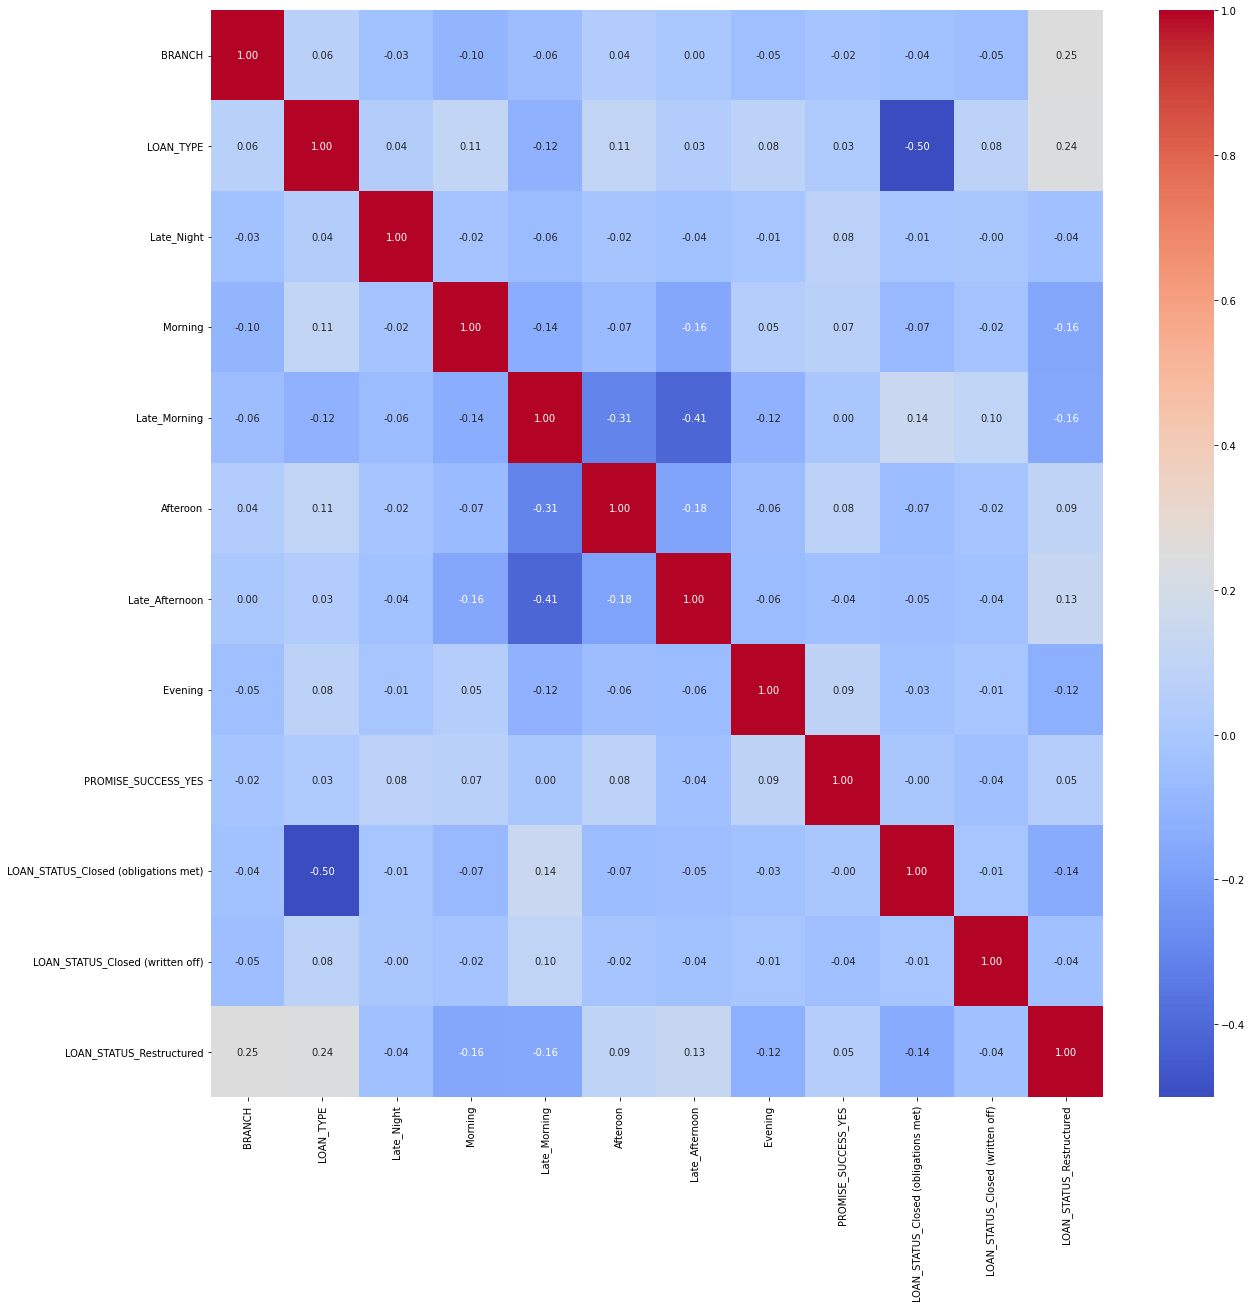

In [25]:
# Corelation Matrix
# added the parameter fmt =.2f for 2 decimal representation
# In a more general situation, when you have two independent variables that are very highly correlated, 
# you definitely should remove one of them because you run into the multicollinearity conundrum and your 
# regression model's regression coefficients related to the two highly correlated variables will be unreliable

plt.figure(figsize=(20,20))
sns.heatmap(df_final[list(df_final.columns)].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.show()

In [26]:
# spliting the data to dependent and independent variable
y = df_final['PREF_SESSION'].copy()
X = df_final.drop('PREF_SESSION', axis=1)

# Splitting the dataset into the Training set and Test set. test size is 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.08, random_state = 4)

In [27]:
# Feature Scaling
# there is no need to apply future scaling on dependent variable

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/home/sabarish/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/sabarish/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/sabarish/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [28]:
param = {
            "n_estimators" : 50,
            "max_depth" : 10,
            "eta" : 0.1,
            "eval_metric" : "error",
            "objective" : "multi:softmax"
        }

In [29]:
# plot feature importance using built-in function
from xgboost import XGBClassifier
from xgboost import plot_importance,plot_tree
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier(**param, num_class = y_train.nunique())

model.fit(X_train,y_train)

# # plot feature importance
# plot_importance(model,xlabel = 'count of the feature used across all tress')
# pyplot.show()

# sorted_idx = np.argsort(model.feature_importances_)[::-1]

# for index in sorted_idx:
#     print([X.columns[index], model.feature_importances_[index]]) 

/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, eval_metric='error', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_class=6, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', ...)

In [30]:
print("Available model classess - ",model.classes_)
print("Total model classess - ",model.n_classes_)

Available model classess -  ['Afteroon' 'Evening' 'Late_Afternoon' 'Late_Morning' 'Late_Night'
 'Morning']
Total model classess -  6


In [31]:
# Save the model
import joblib
joblib.dump(model, 'xgb_callsession_classifier.pkl')

#load the saved model and making predictions 
loaded_model = joblib.load('xgb_callsession_classifier.pkl')
y_pred = loaded_model.predict(X_test)

In [32]:
# confusion matrix for the predictions
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
cnf_matrix = confusion_matrix(y_true = np.array(y_test),y_pred = y_pred, labels = loaded_model.classes_)
print("Confusion matrix \n\n",cnf_matrix)

Confusion matrix 

 [[ 2  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]]


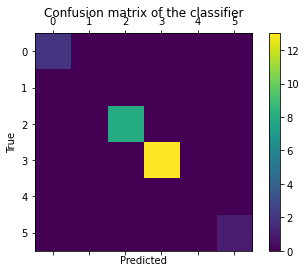

In [33]:
# Confusion matrix plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
# To print the accuracy score
# Accuracy is used when the True Positives and True negatives are more important while 
# F1-score is used when the False Negatives and False Positives are crucial.
# In real-life classification problems,imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on
print('Model Accuracy - ',round(accuracy_score(np.array(y_test), y_pred),3))

Model Accuracy -  1.0


In [35]:
#  F1 score - F-score or F-measure is a measure of a test's accuracy
# Sensitivity(recall) - true positive rate
# specificity - true negative rate
F1_score = f1_score(np.array(y_test), y_pred, average='weighted')
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = np.mean(FP.astype(float))
FN = np.mean(FN.astype(float))
TP = np.mean(TP.astype(float))
TN = np.mean(TN.astype(float))

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("F1 Score - ",np.round(F1_score,3))
print("Sensitivity Score - ",np.round(TPR,3))
print("Specificity Score- ",np.round(TNR,3))
print("False Positive - ",np.round(FPR,3))
print("False Negative - ",np.round(FNR,3))

F1 Score -  1.0
Sensitivity Score -  1.0
Specificity Score-  1.0
False Positive -  0.0
False Negative -  0.0


In [38]:
mysql_connection = mysql.connector.connect(**config)
dfs = pd.read_sql("SELECT * FROM classification$model$information WHERE ID = ( SELECT MAX(ID) FROM classification$model$information where MODEL_NAME ='xgb_callsession_classifier')", con=mysql_connection)
mysql_connection.close()
dfs.head()

,ID,MODEL_NAME,FILE_NAME,SCALAR_NAME,ACCURACY,F1_SCORE,SENSITIVITY,SPECIFICITY,FALSE_POSITIVE,FALSE_NEGATIVE,DATASET_COLUMNS,ONEHOT_LIST,CREATED_BY,CREATED_ON,UPDATED_BY,UPDATED_ON
0,1,xgb_callsession_classifier,Models/xgb_callsession_classifier202208031745.pkl,Models/xgb_callsession_scalar202208031745.pkl,1.0,1.0,1.0,1.0,0.0,0.0,"['BRANCH', 'LOAN_TYPE', 'Late_Night', 'Morning...","[['NO', 'YES'], ['Active', 'Restructured', 'Cl...",ML_USER,2022-08-03 17:45:59,None,None


In [39]:
inputdata = {
            "ID":100165,
            "BRANCH":16,
            "PROMISE_SUCCESS":"YES",
            "LOAN_STATUS":"Closed (obligations met)",
            "LOAN_TYPE":32,
            "STAGE":"COLLECTION"
        }

ONEHOT_LIST = ["PROMISE_SUCCESS","LOAN_STATUS","STAGE"]

INPUT_ONEHOT = [['NO', 'YES'], ['Active', 'Restructured', 'Closed (obligations met)', 'Closed (written off)'],
                ['COLLECTION']]

In [40]:
data = {}
for i in range(0,len(ONEHOT_LIST)):
    for j in INPUT_ONEHOT[i]:  
        if j in inputdata[ONEHOT_LIST[i]]:
            data[ONEHOT_LIST[i]+'_'+ j] = [1]
        else:
            data[ONEHOT_LIST[i]+'_'+ j] = [0]
            
data

{'PROMISE_SUCCESS_NO': [0],
 'PROMISE_SUCCESS_YES': [1],
 'LOAN_STATUS_Active': [0],
 'LOAN_STATUS_Restructured': [0],
 'LOAN_STATUS_Closed (obligations met)': [1],
 'LOAN_STATUS_Closed (written off)': [0],
 'STAGE_COLLECTION': [1]}

In [41]:
d = {'ID':[inputdata['ID']],'BRANCH':[int(inputdata['BRANCH'])],
     'LOAN_TYPE':[int(inputdata['LOAN_TYPE'])]}
d

{'ID': [100165], 'BRANCH': [16], 'LOAN_TYPE': [32]}

In [42]:
from jsonmerge import merge
import pandas as pd

result = merge(d, data)
print(result)
df1 = pd.DataFrame(data=result)
df1.head()

{'ID': [100165], 'BRANCH': [16], 'LOAN_TYPE': [32], 'PROMISE_SUCCESS_NO': [0], 'PROMISE_SUCCESS_YES': [1], 'LOAN_STATUS_Active': [0], 'LOAN_STATUS_Restructured': [0], 'LOAN_STATUS_Closed (obligations met)': [1], 'LOAN_STATUS_Closed (written off)': [0], 'STAGE_COLLECTION': [1]}


,ID,BRANCH,LOAN_TYPE,PROMISE_SUCCESS_NO,PROMISE_SUCCESS_YES,LOAN_STATUS_Active,LOAN_STATUS_Restructured,LOAN_STATUS_Closed (obligations met),LOAN_STATUS_Closed (written off),STAGE_COLLECTION
0,100165,16,32,0,1,0,0,1,0,1


In [43]:
mysql_connection = mysql.connector.connect(**config)
dfa = pd.read_sql_query("select ID,TIME_STAMP from customer$information where ID = '"+str(inputdata['ID'])+"' and PROMISE_SUCCESS = '"+inputdata['PROMISE_SUCCESS']+"'", con=mysql_connection)
mysql_connection.close()
dfa.tail()

,ID,TIME_STAMP


In [44]:
dfa['TIME_STAMP'] = pd.to_datetime(dfa['TIME_STAMP'], errors='coerce')
dfa['SESSION'] = pd.cut(dfa.TIME_STAMP.dt.hour, bins=split, labels=session, include_lowest=True)

# Grouping the ID with sessions to get each customer call count against each session
dfa['FREQ'] = dfa.groupby(["ID","SESSION"])['SESSION'].transform('count')

dfa = dfa.pivot_table(index=['ID'], columns='SESSION', values='FREQ', fill_value=0, dropna=False).reset_index()
dfa.tail()

SESSION,ID,Late_Night,Early_Morning,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,Night


In [45]:
dfa['ID']=dfa['ID'].astype(int)
df = pd.merge(dfa, df1, on=['ID'])
df.head()

,Late_Night,Early_Morning,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,Night,ID,BRANCH,LOAN_TYPE,PROMISE_SUCCESS_NO,PROMISE_SUCCESS_YES,LOAN_STATUS_Active,LOAN_STATUS_Restructured,LOAN_STATUS_Closed (obligations met),LOAN_STATUS_Closed (written off),STAGE_COLLECTION


In [46]:
df = df[eval(dfs['DATASET_COLUMNS'][0])]
df.head()

,BRANCH,LOAN_TYPE,Late_Night,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,PROMISE_SUCCESS_YES,LOAN_STATUS_Closed (obligations met),LOAN_STATUS_Closed (written off),LOAN_STATUS_Restructured


In [47]:
mysql_connection = mysql.connector.connect(**config)
dfc = pd.read_sql_query("select ID,TIME_STAMP from customer$information where ID = '100' and PROMISE_SUCCESS = '"+inputdata['PROMISE_SUCCESS']+"'", con=mysql_connection)
mysql_connection.close()
len(dfc)

0

In [48]:
data1 = {}

for i in session:
    data1[i] = [0]    
data1

{'Late_Night': [0],
 'Early_Morning': [0],
 'Morning': [0],
 'Late_Morning': [0],
 'Afteroon': [0],
 'Late_Afternoon': [0],
 'Evening': [0],
 'Late_Evening': [0],
 'Night': [0]}

In [49]:
from jsonmerge import merge

result = merge(d, data)
result = merge(result,data1)
df1 = pd.DataFrame(data=result)
df1.head()

,ID,BRANCH,LOAN_TYPE,PROMISE_SUCCESS_NO,PROMISE_SUCCESS_YES,LOAN_STATUS_Active,LOAN_STATUS_Restructured,LOAN_STATUS_Closed (obligations met),LOAN_STATUS_Closed (written off),STAGE_COLLECTION,Late_Night,Early_Morning,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,Night
0,100165,16,32,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0


In [50]:
df1 = df1[eval(dfs['DATASET_COLUMNS'][0])]
df1.head()

,BRANCH,LOAN_TYPE,Late_Night,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,PROMISE_SUCCESS_YES,LOAN_STATUS_Closed (obligations met),LOAN_STATUS_Closed (written off),LOAN_STATUS_Restructured
0,16,32,0,0,0,0,0,0,1,1,0,0
